**Import Libraries**

In [1]:
# Standard Libraries
import os
import copy
import random
from glob import glob
from PIL import Image
import timm

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt

# Progress Bar
from tqdm import tqdm

# Machine Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, f1_score

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Define Parameters**

In [2]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

# Parameters training
LEARNING_RATE = 0.001
LEARNING_RATE_FINE_TUNING = 0.0001
EPOCHS = 100
BATCH_SIZE = 32

# Parameters early stopping
EARLY_STOPPING_PATIENCE = 10

# Parameters learning rate scheduler
LEARNING_RATE_SCHEDULER_PATIENCE = 5
LEARNING_RATE_SCHEDULER_MODE = 'min'
LEARNING_RATE_SCHEDULER_FACTOR = 0.1

# Other parameters
SEED = 42
NUM_WORKERS = 32

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Set Seed for Reproducibility**

In [3]:
def seed_everything(seed=SEED):
    """
    Sets the seed to ensure reproducibility.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Apply the seed
seed_everything()

# **Step 1: Load Data**

In [4]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

# Extract ChestX-ray14 dataset
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [5]:
def load_labels(csv_path, extracted_path):
    """
    Read labels from CSV, maps images to paths, and create binary disease labels.
    """

    # Read the CSV containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create binary column for 'No Finding'
    labels_df['No Finding'] = labels_df['Finding Labels'].str.contains('No Finding').astype(int)

    # Map images to their full path
    labels_df['Path'] = labels_df['Image Index'].map(
        {os.path.basename(path): path for path in glob(os.path.join(extracted_path, '**', 'images', '*.png'))}
    )
    
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Split Dataset**

In [6]:
# Split based on patients
unique_patients = df['Patient ID'].unique()

# Split patients into training, validation and test sets
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)
train_patients, val_patients = train_test_split(
    train_val_patients, test_size=0.125, random_state=SEED
)

# Create dataframes for training, validation, and test sets
train_df = df[df['Patient ID'].isin(train_patients)].reset_index(drop=True)
val_df = df[df['Patient ID'].isin(val_patients)].reset_index(drop=True)
test_df = df[df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 78614
Validation size: 11212
Test size: 22294


**Define Dataset for Chest X-ray images**

In [7]:
class ChestXrayDataset(Dataset):
    """
    Create dataset for Chest X-ray images.
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        # Get image and labels
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)
        label = self.df.iloc[idx][disease_labels].values.astype(np.float32)
        
        # Apply transformation on image
        image = self.transform(image)
        
        return image, label

**Define Data Transformations**

In [8]:
# Define transformations for training data
train_transforms = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize(224),

    # Apply random horizontal flip
    transforms.RandomHorizontalFlip(),

    # Randomly rotate the image with ±10 degrees
    transforms.RandomRotation(10),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define transformations for test data
test_transforms = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize(224),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**Create Datasets**

In [9]:
train_dataset = ChestXrayDataset(train_df, transform=train_transforms)
val_dataset = ChestXrayDataset(val_df, transform=test_transforms)
test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

**Create DataLoaders**

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# **Step 3: Build the Model**

**Initialize the Multi-Label Classifier Model**

In [11]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using Swin Transformer as the base model.
    """
    def __init__(self, num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained ConvNeXt v2 model
        self.base_model = timm.create_model('coatnet_2_rw_224.sw_in12k_ft_in1k', pretrained=True)

        # Replace the classification head
        self.base_model.head.fc = nn.Linear(self.base_model.head.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Initialize the Model
model = MultiLabelClassifier()
model.to(device)

MultiLabelClassifier(
  (base_model): MaxxVit(
    (stem): Stem(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm1): BatchNormAct2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (stages): Sequential(
      (0): MaxxVitStage(
        (blocks): Sequential(
          (0): MbConvBlock(
            (shortcut): Downsample2d(
              (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
              (expand): Identity()
            )
            (pre_norm): BatchNormAct2d(
              128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (down): Identity()
            (conv1_1x1): Conv2d(128, 512, kernel_size=(1, 1), st

**Use Multiple GPUs**

In [12]:
model = nn.DataParallel(model)

# **Step 4: Train the Model**

**Step 1: Train Classification Head Only**

In [13]:
# First, freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last 10 parameters
named_params = list(model.named_parameters())
for name, param in named_params[-10:]:
    param.requires_grad = True

In [14]:
# Initialize loss function
criterion = nn.BCEWithLogitsLoss()

# Initialize optimizer
optimizer_head = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)

# Initialize scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_head, factor=LEARNING_RATE_SCHEDULER_FACTOR, patience=LEARNING_RATE_SCHEDULER_PATIENCE, mode=LEARNING_RATE_SCHEDULER_MODE)

In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, patience, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    # Early stopping parameters
    best_score = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)

        # Update the scheduler
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Mean Validation AUC: {mean_auc:.4f}")

        # Early stopping
        if mean_auc > best_score:
            best_score = mean_auc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model.pt')
            print(f"New best model saved with Mean Validation AUC: {mean_auc:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping. No improvement for {patience} epochs")
                break
                
    # Load the best model
    model.load_state_dict(torch.load('best_model.pt', weights_only=True))

    return train_losses, val_losses, val_aucs

# Train the model
train_losses_1, val_losses_1, val_aucs_1 = train_model(model, train_loader, val_loader, criterion, optimizer_head, EARLY_STOPPING_PATIENCE, EPOCHS)

Epoch 1/100:   0%|          | 0/2457 [00:00<?, ?it/s]

Epoch 1/100: 100%|██████████| 351/351 [00:18<00:00, 19.24it/s, Loss=0.139] 


Epoch 1/100 | Training Loss: 0.1745 | Validation Loss: 0.1691 | Mean Validation AUC: 0.7275
New best model saved with Mean Validation AUC: 0.7275


Epoch 2/100: 100%|██████████| 351/351 [00:13<00:00, 26.18it/s, Loss=0.131] 


Epoch 2/100 | Training Loss: 0.1690 | Validation Loss: 0.1662 | Mean Validation AUC: 0.7459
New best model saved with Mean Validation AUC: 0.7459


Epoch 3/100: 100%|██████████| 351/351 [00:13<00:00, 26.27it/s, Loss=0.132] 


Epoch 3/100 | Training Loss: 0.1670 | Validation Loss: 0.1651 | Mean Validation AUC: 0.7493
New best model saved with Mean Validation AUC: 0.7493


Epoch 4/100: 100%|██████████| 351/351 [00:13<00:00, 26.26it/s, Loss=0.141] 


Epoch 4/100 | Training Loss: 0.1662 | Validation Loss: 0.1627 | Mean Validation AUC: 0.7541
New best model saved with Mean Validation AUC: 0.7541


Epoch 5/100: 100%|██████████| 351/351 [00:13<00:00, 26.55it/s, Loss=0.14]  


Epoch 5/100 | Training Loss: 0.1652 | Validation Loss: 0.1617 | Mean Validation AUC: 0.7562
New best model saved with Mean Validation AUC: 0.7562


Epoch 6/100: 100%|██████████| 351/351 [00:13<00:00, 26.16it/s, Loss=0.138] 


Epoch 6/100 | Training Loss: 0.1643 | Validation Loss: 0.1616 | Mean Validation AUC: 0.7605
New best model saved with Mean Validation AUC: 0.7605


Epoch 7/100: 100%|██████████| 351/351 [00:13<00:00, 26.37it/s, Loss=0.128] 


Epoch 7/100 | Training Loss: 0.1636 | Validation Loss: 0.1652 | Mean Validation AUC: 0.7450


Epoch 8/100: 100%|██████████| 351/351 [00:13<00:00, 26.27it/s, Loss=0.134] 


Epoch 8/100 | Training Loss: 0.1629 | Validation Loss: 0.1622 | Mean Validation AUC: 0.7641
New best model saved with Mean Validation AUC: 0.7641


Epoch 9/100: 100%|██████████| 351/351 [00:13<00:00, 26.07it/s, Loss=0.125] 


Epoch 9/100 | Training Loss: 0.1627 | Validation Loss: 0.1626 | Mean Validation AUC: 0.7652
New best model saved with Mean Validation AUC: 0.7652


Epoch 10/100: 100%|██████████| 351/351 [00:13<00:00, 25.89it/s, Loss=0.134] 


Epoch 10/100 | Training Loss: 0.1620 | Validation Loss: 0.1623 | Mean Validation AUC: 0.7684
New best model saved with Mean Validation AUC: 0.7684


Epoch 11/100: 100%|██████████| 351/351 [00:13<00:00, 25.92it/s, Loss=0.125] 


Epoch 11/100 | Training Loss: 0.1617 | Validation Loss: 0.1616 | Mean Validation AUC: 0.7652


Epoch 12/100: 100%|██████████| 351/351 [00:13<00:00, 26.58it/s, Loss=0.128] 


Epoch 12/100 | Training Loss: 0.1613 | Validation Loss: 0.1614 | Mean Validation AUC: 0.7688
New best model saved with Mean Validation AUC: 0.7688


Epoch 13/100: 100%|██████████| 351/351 [00:13<00:00, 26.14it/s, Loss=0.131] 


Epoch 13/100 | Training Loss: 0.1610 | Validation Loss: 0.1597 | Mean Validation AUC: 0.7688


Epoch 14/100: 100%|██████████| 351/351 [00:13<00:00, 26.31it/s, Loss=0.129] 


Epoch 14/100 | Training Loss: 0.1605 | Validation Loss: 0.1610 | Mean Validation AUC: 0.7681


Epoch 15/100: 100%|██████████| 351/351 [00:13<00:00, 26.02it/s, Loss=0.133] 


Epoch 15/100 | Training Loss: 0.1601 | Validation Loss: 0.1628 | Mean Validation AUC: 0.7611


Epoch 16/100: 100%|██████████| 351/351 [00:13<00:00, 26.13it/s, Loss=0.132] 


Epoch 16/100 | Training Loss: 0.1597 | Validation Loss: 0.1611 | Mean Validation AUC: 0.7717
New best model saved with Mean Validation AUC: 0.7717


Epoch 17/100: 100%|██████████| 351/351 [00:13<00:00, 26.26it/s, Loss=0.123] 


Epoch 17/100 | Training Loss: 0.1595 | Validation Loss: 0.1599 | Mean Validation AUC: 0.7681


Epoch 18/100: 100%|██████████| 351/351 [00:13<00:00, 25.88it/s, Loss=0.127] 


Epoch 18/100 | Training Loss: 0.1592 | Validation Loss: 0.1600 | Mean Validation AUC: 0.7712


Epoch 19/100: 100%|██████████| 351/351 [00:13<00:00, 26.31it/s, Loss=0.131] 


Epoch 19/100 | Training Loss: 0.1589 | Validation Loss: 0.1595 | Mean Validation AUC: 0.7703


Epoch 20/100: 100%|██████████| 351/351 [00:13<00:00, 25.73it/s, Loss=0.14]  


Epoch 20/100 | Training Loss: 0.1585 | Validation Loss: 0.1613 | Mean Validation AUC: 0.7685


Epoch 21/100: 100%|██████████| 351/351 [00:13<00:00, 25.94it/s, Loss=0.133] 


Epoch 21/100 | Training Loss: 0.1582 | Validation Loss: 0.1600 | Mean Validation AUC: 0.7694


Epoch 22/100: 100%|██████████| 351/351 [00:13<00:00, 25.84it/s, Loss=0.126] 


Epoch 22/100 | Training Loss: 0.1580 | Validation Loss: 0.1616 | Mean Validation AUC: 0.7709


Epoch 23/100: 100%|██████████| 351/351 [00:13<00:00, 26.11it/s, Loss=0.131] 


Epoch 23/100 | Training Loss: 0.1576 | Validation Loss: 0.1605 | Mean Validation AUC: 0.7695


Epoch 24/100: 100%|██████████| 351/351 [00:13<00:00, 26.14it/s, Loss=0.123] 


Epoch 24/100 | Training Loss: 0.1574 | Validation Loss: 0.1596 | Mean Validation AUC: 0.7726
New best model saved with Mean Validation AUC: 0.7726


Epoch 25/100: 100%|██████████| 351/351 [00:13<00:00, 26.00it/s, Loss=0.134] 


Epoch 25/100 | Training Loss: 0.1572 | Validation Loss: 0.1614 | Mean Validation AUC: 0.7687


Epoch 26/100: 100%|██████████| 351/351 [00:13<00:00, 26.11it/s, Loss=0.129] 


Epoch 26/100 | Training Loss: 0.1543 | Validation Loss: 0.1589 | Mean Validation AUC: 0.7707


Epoch 27/100: 100%|██████████| 351/351 [00:13<00:00, 25.94it/s, Loss=0.127] 


Epoch 27/100 | Training Loss: 0.1538 | Validation Loss: 0.1589 | Mean Validation AUC: 0.7701


Epoch 28/100: 100%|██████████| 351/351 [00:13<00:00, 26.12it/s, Loss=0.13]  


Epoch 28/100 | Training Loss: 0.1532 | Validation Loss: 0.1591 | Mean Validation AUC: 0.7688


Epoch 29/100: 100%|██████████| 351/351 [00:13<00:00, 25.83it/s, Loss=0.127] 


Epoch 29/100 | Training Loss: 0.1532 | Validation Loss: 0.1588 | Mean Validation AUC: 0.7711


Epoch 30/100: 100%|██████████| 351/351 [00:13<00:00, 26.03it/s, Loss=0.128] 


Epoch 30/100 | Training Loss: 0.1527 | Validation Loss: 0.1593 | Mean Validation AUC: 0.7682


Epoch 31/100: 100%|██████████| 351/351 [00:13<00:00, 25.99it/s, Loss=0.126] 


Epoch 31/100 | Training Loss: 0.1529 | Validation Loss: 0.1592 | Mean Validation AUC: 0.7698


Epoch 32/100: 100%|██████████| 351/351 [00:13<00:00, 26.09it/s, Loss=0.124] 


Epoch 32/100 | Training Loss: 0.1526 | Validation Loss: 0.1591 | Mean Validation AUC: 0.7710


Epoch 33/100: 100%|██████████| 351/351 [00:13<00:00, 26.28it/s, Loss=0.128] 


Epoch 33/100 | Training Loss: 0.1526 | Validation Loss: 0.1595 | Mean Validation AUC: 0.7696


Epoch 34/100: 100%|██████████| 351/351 [00:13<00:00, 26.06it/s, Loss=0.131] 


Epoch 34/100 | Training Loss: 0.1524 | Validation Loss: 0.1598 | Mean Validation AUC: 0.7682
Early stopping. No improvement for 10 epochs


**Step 2: Fine Tune Entire Network**

In [16]:
# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

In [17]:
# Initialize optimizer
optimizer_full = optim.Adam(model.parameters(), lr=LEARNING_RATE_FINE_TUNING)

# Initialize scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_full, factor=LEARNING_RATE_SCHEDULER_FACTOR, patience=LEARNING_RATE_SCHEDULER_PATIENCE, mode=LEARNING_RATE_SCHEDULER_MODE)

In [18]:
def train_model(model, train_loader, val_loader, criterion, optimizer, patience, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    # Early stopping parameters
    best_score = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)

        # Update the scheduler
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Mean Validation AUC: {mean_auc:.4f}")

        # Early stopping
        if mean_auc > best_score:
            best_score = mean_auc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model.pt')
            print(f"New best model saved with Mean Validation AUC: {mean_auc:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping. No improvement for {patience:.4f} epochs")
                break

    # Load the best model
    model.load_state_dict(torch.load('best_model.pt', weights_only=True))

    return train_losses, val_losses, val_aucs

# Train the model for the desired number of epochs
train_losses_2, val_losses_2, val_aucs_2 = train_model(model, train_loader, val_loader, criterion, optimizer_full, EARLY_STOPPING_PATIENCE, EPOCHS)

Epoch 1/100:   0%|          | 0/2457 [00:00<?, ?it/s]

Epoch 1/100: 100%|██████████| 351/351 [00:13<00:00, 25.96it/s, Loss=0.144] 


Epoch 1/100 | Training Loss: 0.1722 | Validation Loss: 0.1661 | Mean Validation AUC: 0.7288
New best model saved with Mean Validation AUC: 0.7288


Epoch 2/100: 100%|██████████| 351/351 [00:13<00:00, 25.71it/s, Loss=0.138] 


Epoch 2/100 | Training Loss: 0.1638 | Validation Loss: 0.1566 | Mean Validation AUC: 0.7705
New best model saved with Mean Validation AUC: 0.7705


Epoch 3/100: 100%|██████████| 351/351 [00:13<00:00, 25.84it/s, Loss=0.123] 


Epoch 3/100 | Training Loss: 0.1580 | Validation Loss: 0.1546 | Mean Validation AUC: 0.7928
New best model saved with Mean Validation AUC: 0.7928


Epoch 4/100: 100%|██████████| 351/351 [00:13<00:00, 25.71it/s, Loss=0.14]  


Epoch 4/100 | Training Loss: 0.1540 | Validation Loss: 0.1514 | Mean Validation AUC: 0.7979
New best model saved with Mean Validation AUC: 0.7979


Epoch 5/100: 100%|██████████| 351/351 [00:13<00:00, 25.92it/s, Loss=0.114] 


Epoch 5/100 | Training Loss: 0.1511 | Validation Loss: 0.1479 | Mean Validation AUC: 0.8171
New best model saved with Mean Validation AUC: 0.8171


Epoch 6/100: 100%|██████████| 351/351 [00:13<00:00, 25.62it/s, Loss=0.115] 


Epoch 6/100 | Training Loss: 0.1482 | Validation Loss: 0.1480 | Mean Validation AUC: 0.8191
New best model saved with Mean Validation AUC: 0.8191


Epoch 7/100: 100%|██████████| 351/351 [00:13<00:00, 25.96it/s, Loss=0.101] 


Epoch 7/100 | Training Loss: 0.1461 | Validation Loss: 0.1477 | Mean Validation AUC: 0.8271
New best model saved with Mean Validation AUC: 0.8271


Epoch 8/100: 100%|██████████| 351/351 [00:13<00:00, 25.95it/s, Loss=0.103] 


Epoch 8/100 | Training Loss: 0.1443 | Validation Loss: 0.1452 | Mean Validation AUC: 0.8290
New best model saved with Mean Validation AUC: 0.8290


Epoch 9/100: 100%|██████████| 351/351 [00:13<00:00, 25.81it/s, Loss=0.128] 


Epoch 9/100 | Training Loss: 0.1425 | Validation Loss: 0.1446 | Mean Validation AUC: 0.8274


Epoch 10/100: 100%|██████████| 351/351 [00:13<00:00, 25.32it/s, Loss=0.109] 


Epoch 10/100 | Training Loss: 0.1410 | Validation Loss: 0.1443 | Mean Validation AUC: 0.8315
New best model saved with Mean Validation AUC: 0.8315


Epoch 11/100: 100%|██████████| 351/351 [00:13<00:00, 25.54it/s, Loss=0.121] 


Epoch 11/100 | Training Loss: 0.1397 | Validation Loss: 0.1433 | Mean Validation AUC: 0.8344
New best model saved with Mean Validation AUC: 0.8344


Epoch 12/100: 100%|██████████| 351/351 [00:13<00:00, 25.56it/s, Loss=0.113] 


Epoch 12/100 | Training Loss: 0.1382 | Validation Loss: 0.1429 | Mean Validation AUC: 0.8381
New best model saved with Mean Validation AUC: 0.8381


Epoch 13/100: 100%|██████████| 351/351 [00:13<00:00, 25.57it/s, Loss=0.112] 


Epoch 13/100 | Training Loss: 0.1367 | Validation Loss: 0.1460 | Mean Validation AUC: 0.8366


Epoch 14/100: 100%|██████████| 351/351 [00:13<00:00, 26.16it/s, Loss=0.127] 


Epoch 14/100 | Training Loss: 0.1353 | Validation Loss: 0.1439 | Mean Validation AUC: 0.8386
New best model saved with Mean Validation AUC: 0.8386


Epoch 15/100: 100%|██████████| 351/351 [00:15<00:00, 22.04it/s, Loss=0.109] 


Epoch 15/100 | Training Loss: 0.1340 | Validation Loss: 0.1446 | Mean Validation AUC: 0.8433
New best model saved with Mean Validation AUC: 0.8433


Epoch 16/100: 100%|██████████| 351/351 [00:13<00:00, 25.98it/s, Loss=0.106] 


Epoch 16/100 | Training Loss: 0.1323 | Validation Loss: 0.1441 | Mean Validation AUC: 0.8395


Epoch 17/100: 100%|██████████| 351/351 [00:13<00:00, 25.87it/s, Loss=0.12]  


Epoch 17/100 | Training Loss: 0.1309 | Validation Loss: 0.1444 | Mean Validation AUC: 0.8398


Epoch 18/100: 100%|██████████| 351/351 [00:13<00:00, 25.88it/s, Loss=0.113] 


Epoch 18/100 | Training Loss: 0.1294 | Validation Loss: 0.1449 | Mean Validation AUC: 0.8402


Epoch 19/100: 100%|██████████| 351/351 [00:13<00:00, 25.85it/s, Loss=0.125] 


Epoch 19/100 | Training Loss: 0.1211 | Validation Loss: 0.1462 | Mean Validation AUC: 0.8447
New best model saved with Mean Validation AUC: 0.8447


Epoch 20/100: 100%|██████████| 351/351 [00:13<00:00, 26.02it/s, Loss=0.126] 


Epoch 20/100 | Training Loss: 0.1180 | Validation Loss: 0.1482 | Mean Validation AUC: 0.8416


Epoch 21/100: 100%|██████████| 351/351 [00:13<00:00, 25.72it/s, Loss=0.125] 


Epoch 21/100 | Training Loss: 0.1159 | Validation Loss: 0.1496 | Mean Validation AUC: 0.8405


Epoch 22/100: 100%|██████████| 351/351 [00:13<00:00, 25.69it/s, Loss=0.134] 


Epoch 22/100 | Training Loss: 0.1146 | Validation Loss: 0.1511 | Mean Validation AUC: 0.8373


Epoch 23/100: 100%|██████████| 351/351 [00:13<00:00, 25.76it/s, Loss=0.128] 


Epoch 23/100 | Training Loss: 0.1134 | Validation Loss: 0.1512 | Mean Validation AUC: 0.8360


Epoch 24/100: 100%|██████████| 351/351 [00:13<00:00, 25.76it/s, Loss=0.125] 


Epoch 24/100 | Training Loss: 0.1122 | Validation Loss: 0.1524 | Mean Validation AUC: 0.8350


Epoch 25/100: 100%|██████████| 351/351 [00:13<00:00, 25.80it/s, Loss=0.132] 


Epoch 25/100 | Training Loss: 0.1101 | Validation Loss: 0.1539 | Mean Validation AUC: 0.8343


Epoch 26/100: 100%|██████████| 351/351 [00:13<00:00, 25.81it/s, Loss=0.128] 


Epoch 26/100 | Training Loss: 0.1101 | Validation Loss: 0.1538 | Mean Validation AUC: 0.8339


Epoch 27/100: 100%|██████████| 351/351 [00:13<00:00, 25.92it/s, Loss=0.134] 


Epoch 27/100 | Training Loss: 0.1096 | Validation Loss: 0.1546 | Mean Validation AUC: 0.8339


Epoch 28/100: 100%|██████████| 351/351 [00:13<00:00, 25.72it/s, Loss=0.134] 


Epoch 28/100 | Training Loss: 0.1095 | Validation Loss: 0.1547 | Mean Validation AUC: 0.8329


Epoch 29/100: 100%|██████████| 351/351 [00:13<00:00, 25.71it/s, Loss=0.131] 


Epoch 29/100 | Training Loss: 0.1095 | Validation Loss: 0.1551 | Mean Validation AUC: 0.8328
Early stopping. No improvement for 10.0000 epochs


# **Step 5: Evaluate the Model**

**Test-time Augmentations**

In [19]:
tta_transforms = [
    lambda img: img,
    lambda img: transforms.RandomHorizontalFlip(p=1.0)(img),
    lambda img: transforms.RandomRotation(10)(img)
]

**Evaluate the Model**

In [20]:
def evaluate_model(model, test_loader):
    """
    Evaluates the model on the test set and returns predictions and true labels.
    """
    model.eval()
    all_preds = []
    all_labels = []

    # Progress bar
    progress_bar = tqdm(test_loader, desc="Evaluating on Test Set")

    # Disable gradients for evaluation
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)

            tta_preds = []
            
            # Apply each TTA transformation and predict
            for tta in tta_transforms:
                augmented_inputs = tta(inputs)
                outputs = model(augmented_inputs)
                preds = torch.sigmoid(outputs)
                tta_preds.append(preds)

            # Average the predictions across TTA transforms
            avg_preds = torch.stack(tta_preds).mean(dim=0).cpu()

            # Store predictions and true labels
            all_preds.append(avg_preds)
            all_labels.append(labels)

    # Concatenate all batches
    preds = torch.cat(all_preds)
    labels = torch.cat(all_labels)
    return preds, labels

# Get predictions and true labels
preds, labels = evaluate_model(model, test_loader)

Evaluating on Test Set: 100%|██████████| 697/697 [01:01<00:00, 11.40it/s]


**Compute Metrics for Each Label**

In [21]:
# Initialize dictionaries for metrics
accuracy_per_label = {}
f1_per_label = {}
roc_auc_per_label = {}

# Compute metrics for each label
for i, label in enumerate(disease_labels):
    
    # Binarize predictions with threshold 0.5
    binary_preds = preds[:, i] > 0.5

    # Calculate accuracy
    acc = accuracy_score(labels[:, i], binary_preds)

    # Calculate f1 score
    f1 = f1_score(labels[:, i], binary_preds, average='macro')

    # Calculate ROC AUC
    roc_auc = roc_auc_score(labels[:, i], preds[:, i])

    # Store metrics
    accuracy_per_label[label] = acc
    f1_per_label[label] = f1
    roc_auc_per_label[label] = roc_auc

# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_per_label,
    'F1 Score': f1_per_label,
    'ROC AUC': roc_auc_per_label
})

# Calculate the mean for all diseases
metrics_df.loc['Overall'] = metrics_df.mean()

# Print dataframe with metrics
metrics_df

,Accuracy,F1 Score,ROC AUC
Atelectasis,0.900556,0.630536,0.828304
Consolidation,0.956580,0.496029,0.822903
Infiltration,0.810128,0.557923,0.725681
Pneumothorax,0.953979,0.633827,0.875586
Edema,0.978514,0.538374,0.891147
Emphysema,0.976900,0.702489,0.936379
Fibrosis,0.983404,0.503794,0.803631
Effusion,0.899883,0.723287,0.884797
Pneumonia,0.986813,0.496681,0.748773
Pleural_Thickening,0.969454,0.521283,0.807878


**Plot ROC curves for each label**

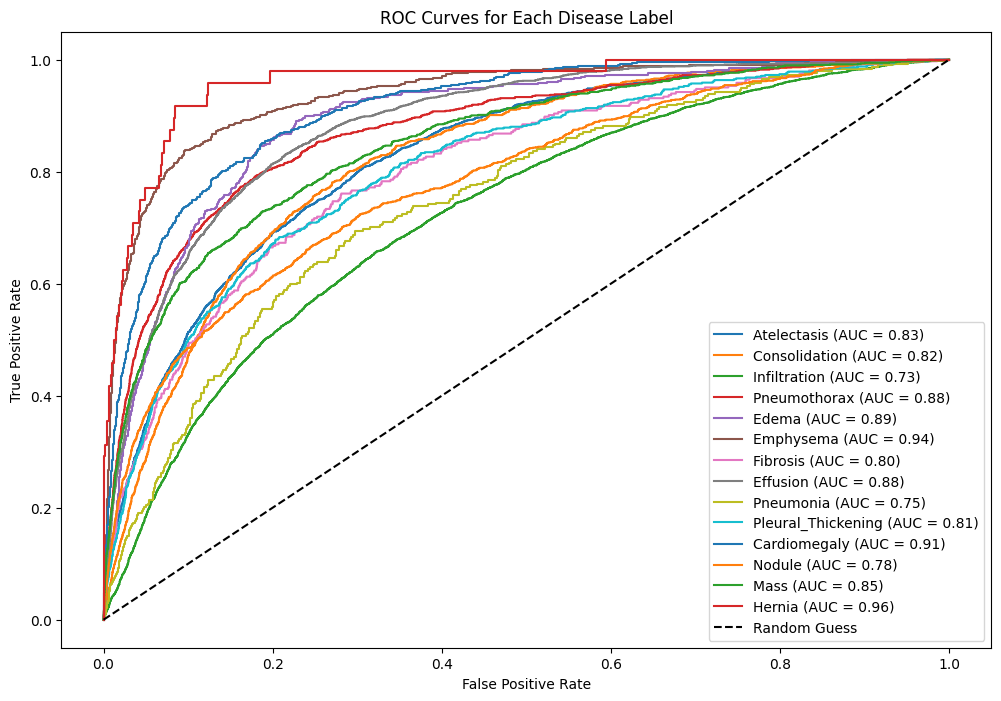

In [22]:
# Plot ROC curves
plt.figure(figsize=(12, 8))
for i, label in enumerate(disease_labels):
    fpr, tpr, _ = roc_curve(labels[:, i], preds[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_per_label[label]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Disease Label')
plt.legend(loc='lower right')
plt.show()

**Plot Training and Validation Loss**

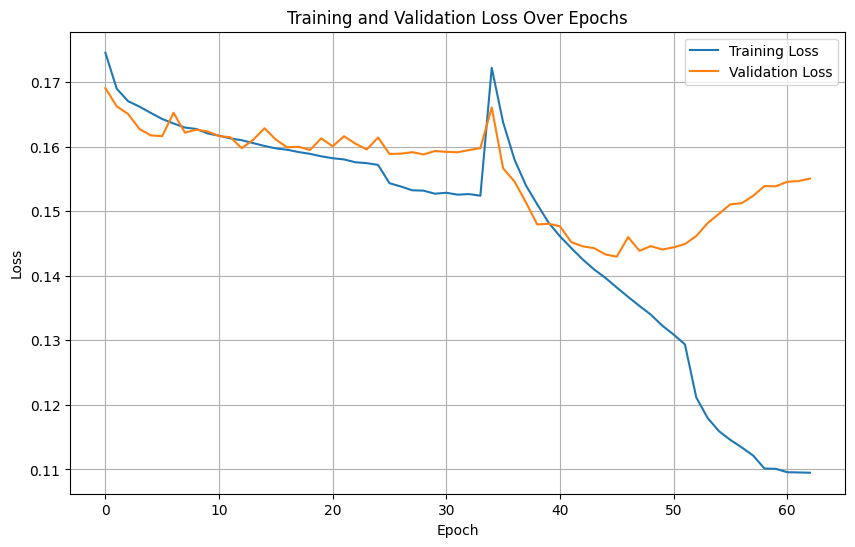

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_1 + train_losses_2, label='Training Loss')
plt.plot(val_losses_1 + val_losses_2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Training and Validation Loss only Fine-tuning**

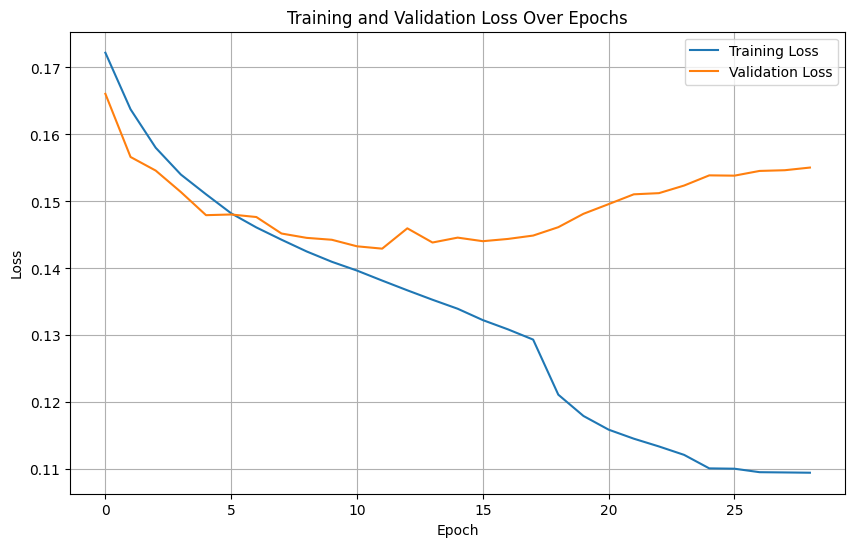

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_2, label='Training Loss')
plt.plot(val_losses_2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC**

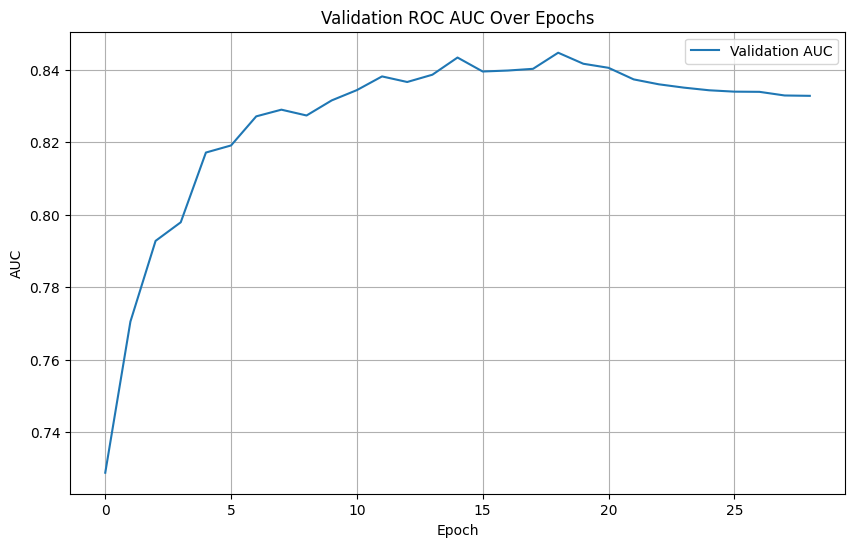

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs_2, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC only Fine-tuning**

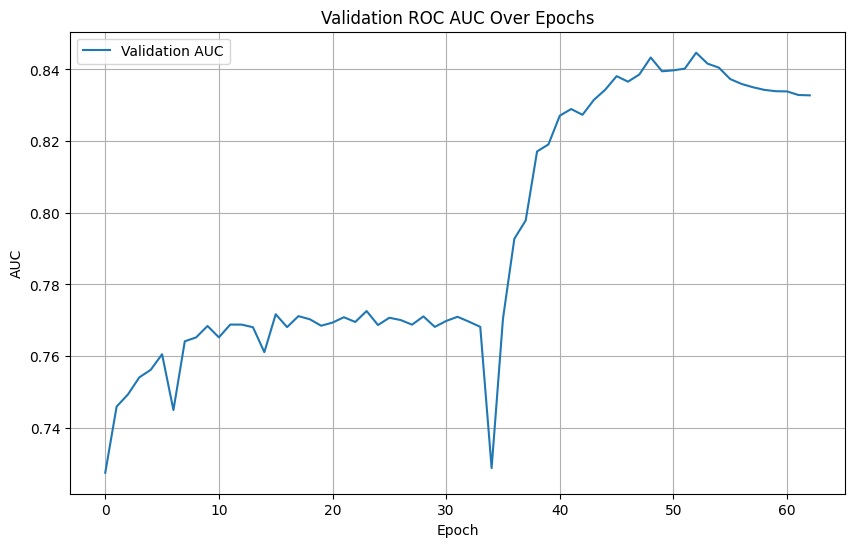

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs_1 + val_aucs_2, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()